In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import pingouin as pg
from scipy import stats
from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import (linkage, optimal_leaf_ordering, leaves_list, dendrogram)

/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
fc = pd.read_pickle('../../DerivedData/matrices/functional/correlation.pickle')
gc = pd.read_csv('../../DerivedData/matrices/clustering_GM_reasigned_silhouette.csv', index_col=0)
groups = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
gc_group = pd.read_pickle('../../DerivedData/matrices/gm/gm_correlome_3groups')
relabeled_encoding=pd.read_csv('../../DerivedData/lookup_parcellation_labels_lobe_grouping.csv')
ages = pd.read_csv('../../DerivedData/all3groups_with_ages.csv', index_col=0)

In [4]:
fc_groups = {}

fc_std = {}

#fc_negative = {}
for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    if group == 'PT: Ses1':
        name = 'PT_session1_id'
    elif group == 'PT: Ses2': 
        name = 'PT_session2_id'
    else:
        name = 'FT_session_id'
    fc_ar = []  
    for ses_id in groups[name].values:
        if np.shape(fc[str(int(ses_id))]) == (75,75):
           fc_ar.append(fc[str(int(ses_id))])
    fc_ar = np.array(fc_ar)
    #mean_ar = np.mean(fc_ar, axis=0)
    #fc_negative[group] = mean_ar
    fc_ar[np.where(fc_ar <0)] = 0
    mean_ar = np.mean(fc_ar, axis=0)
    fc_groups[group] = mean_ar
    
    fc_std[group] = np.mean(fc_ar, axis=0)
    

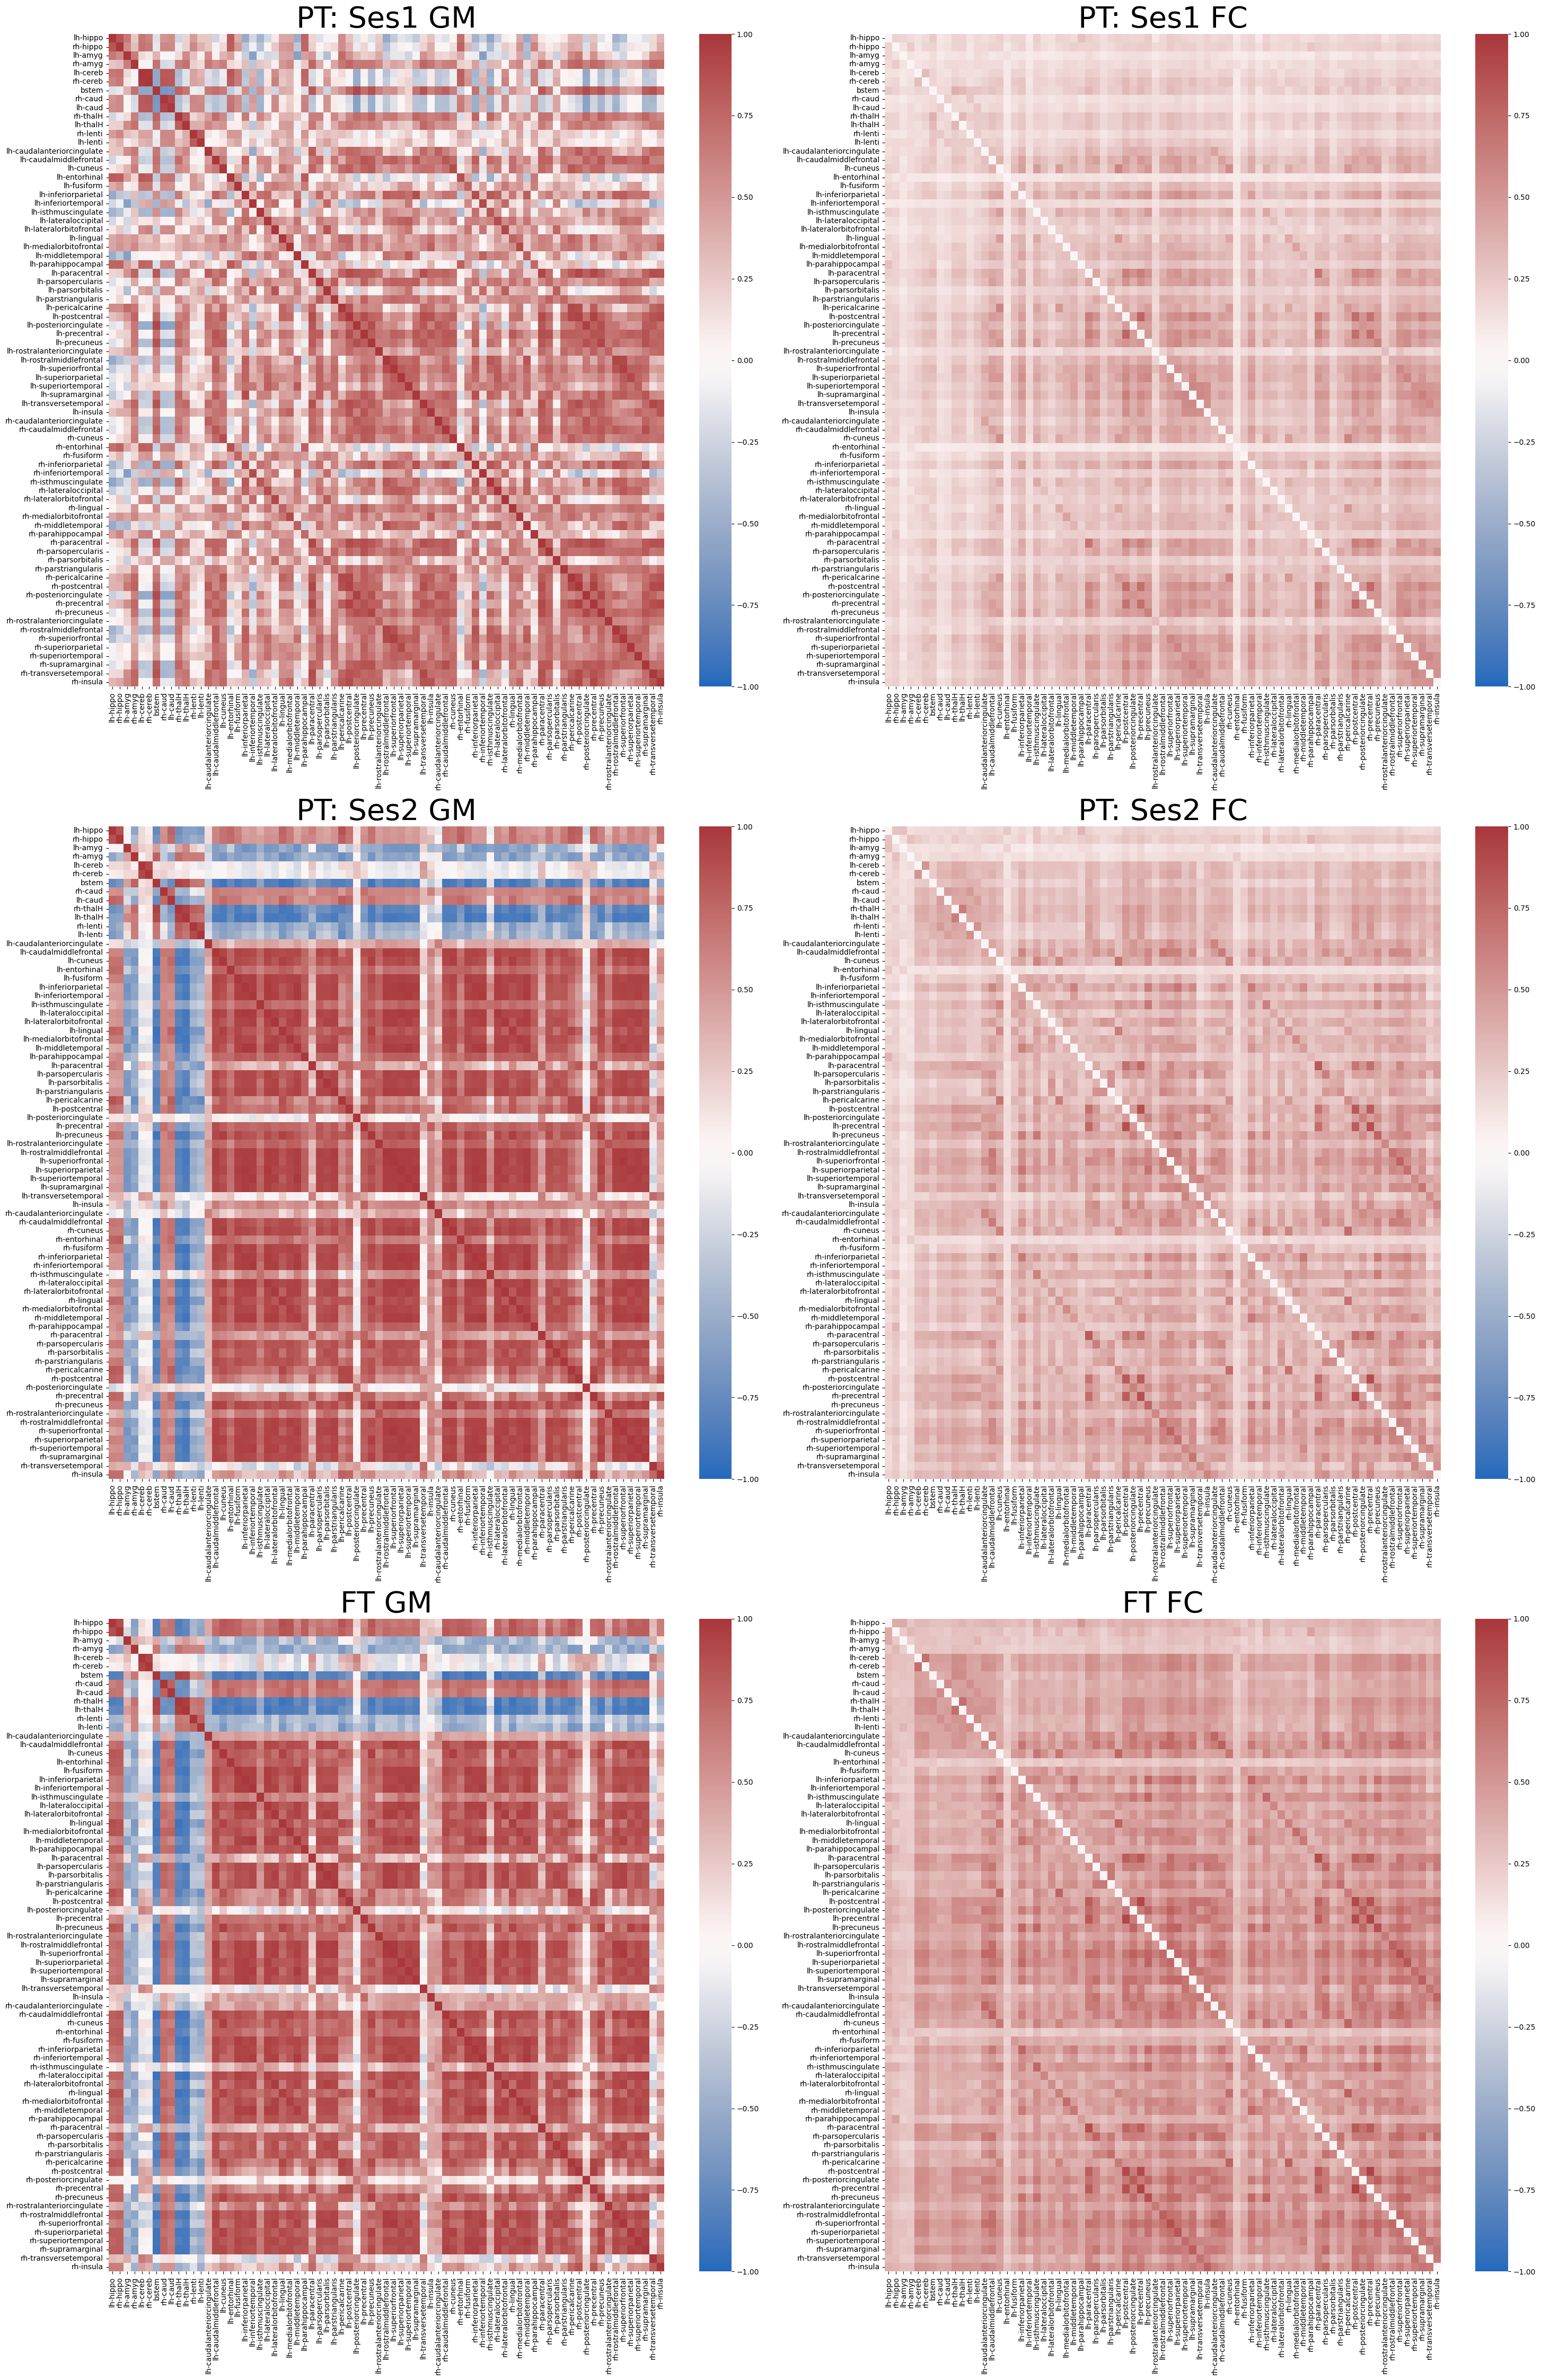

In [5]:
fig, axs = plt.subplots(3,2, figsize=(30,45))
cmap = sns.color_palette("vlag", as_cmap=True)

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    g = gc_group[group].values.copy()
    np.fill_diagonal(g , 0)
    #g[g<0] =  0
    sns.heatmap(gc_group[group], 
            xticklabels=relabeled_encoding['ROI'].values,
            yticklabels=relabeled_encoding['ROI'].values, cmap = cmap, ax=axs[loc,0], vmin=-1, vmax=1) 
    axs[loc, 0].set_title('{} GM'.format(group), fontsize=40)
    
    sns.heatmap(fc_groups[group], 
            xticklabels=relabeled_encoding['ROI'].values,
            yticklabels=relabeled_encoding['ROI'].values, cmap = cmap, ax=axs[loc,1], vmin=-1, vmax=1)
    axs[loc, 1].set_title('{} FC'.format(group), fontsize=40)
    
plt.tight_layout()
plt.show()

## Corcular representation

In [6]:
from pycirclize import Circos
from scipy.stats import t

lobe_names = {
    'C': 'Cingular', 
    'F': 'Frontal', 
    'I': 'Insular', 
    'O': 'Occipital', 
    'P': 'Parietal', 
    'S': 'Subcortical', 
    'T': 'Temporal'    
}

colors = ['tomato', 'cyan', 'lime', 'magenta', 'peru', 'gray', 'yellow']


nodes = relabeled_encoding.copy()[['new_label', 'ROI', 'lobe']]
nodes['new_label'] = nodes['new_label'] - 1

nodes['hemi'] = [ val.split('-')[0] for val in nodes['ROI'].values]
nodes['region'] = [ val.split('-')[-1] for val in nodes['ROI'].values]
nodes.loc[~nodes.hemi.isin(['lh', 'rh']), 'hemi'] = 'bi'
nodes.sort_values(by=['lobe', 'hemi', 'region'], inplace=True)
nodes.reset_index(inplace=True, drop=True)

In [7]:
## get thresholds 
thresholds = {}
for connectome in ['gc', 'fc']:
    l = []
    for group in ['PT: Ses1', 'PT: Ses2', 'FT']:
        if connectome == 'gc':
            matrix = gc_group[group].values.copy()
        else: 
            matrix = fc_groups[group]
            
        idx = np.triu_indices_from(matrix, k = 1)
        l.append(np.abs(matrix[idx]))
    l = np.sort(np.array(l).ravel())
    thr = l[-int(len(l)*0.25)]
    
    thresholds[connectome] = np.round(thr,3)

In [7]:
### shared thresholds
thresholds

{'gc': 0.786, 'fc': 0.448}

In [8]:
ind_thresholds = {}
for connectome in ['gc', 'fc']:
    #l = []
    for group in ['PT: Ses1', 'PT: Ses2', 'FT']:
        if connectome == 'gc':
            matrix = gc_group[group].values.copy()
        else: 
            matrix = fc_groups[group]
            
        idx = np.triu_indices_from(matrix, k = 1)
        l = np.abs(matrix[idx])
        l = np.sort(np.array(l).ravel())
        thr = l[-int(len(l)*0.25)]
    
        ind_thresholds['{}_{}'.format(group, connectome)] = np.round(thr,3)

In [9]:
ind_thresholds

{'PT: Ses1_gc': 0.657,
 'PT: Ses2_gc': 0.856,
 'FT_gc': 0.833,
 'PT: Ses1_fc': 0.349,
 'PT: Ses2_fc': 0.409,
 'FT_fc': 0.537}

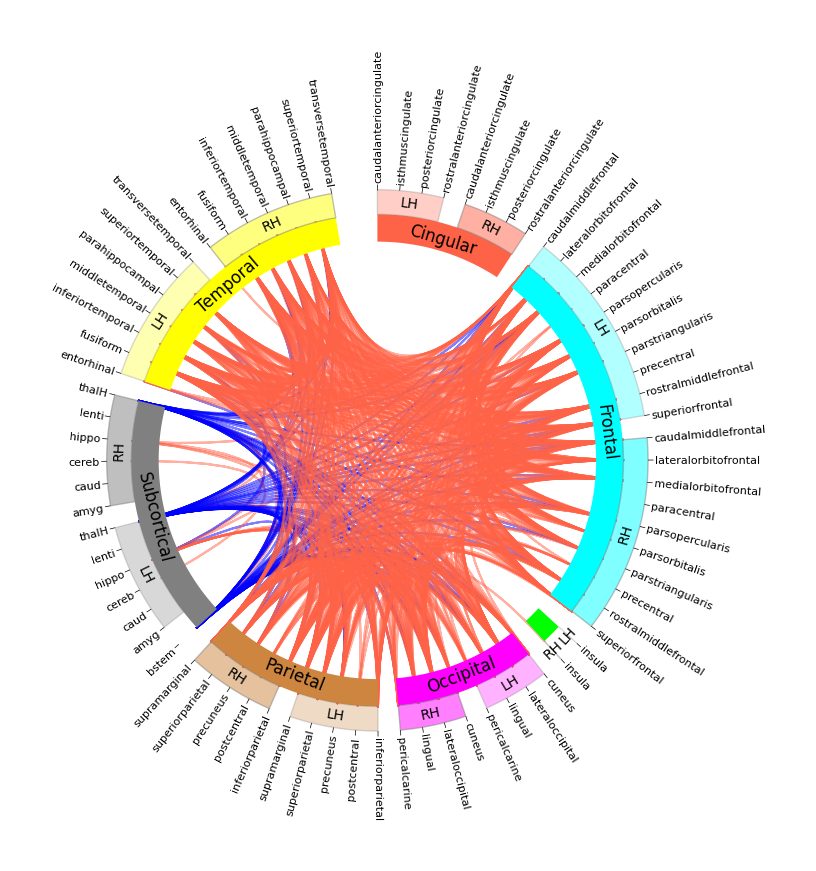

In [10]:
###my 
group = 'FT' #'FT' #
connectome = 'gc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

# initialize sectors 
sectors = {}
for lobe in np.unique(nodes.lobe.values): 
    sectors[lobe] = len(nodes[nodes.lobe == lobe])
    

circos = Circos({'ROIS': 75}, space=5, start=0, end=360 )
for i, sector in enumerate(circos.sectors):
    track = sector.add_track((90, 99))
    pos_list = list(range(0, int(sector.size) ))
    track.xticks(pos_list,nodes.region.values, label_orientation="vertical")
    
    start = sector.start
    for i, lobe in enumerate(sectors.keys()):
        sector.rect(start, start + sectors[lobe]-1, 
                r_lim=(80,90),color=colors[i], alpha=1)
        
        if lobe != 'I':
            sector.text(lobe_names[lobe], 
                    (start+ start + sectors[lobe]-1)/2, color='black', 
                   r=81, size=12)
              
        ## hemi 
        if lobe != 'S':
            sector.rect(start, start + sectors[lobe]/2-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
            
            sector.text('LH', 
                    (start+ start + sectors[lobe]/2 -1)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)
            sector.text('RH', 
                    (start+ sectors[lobe]/2 + start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
            
        else: 
            sector.rect(start+1, start + sectors[lobe]/2 -0.5, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
                
            sector.text('LH', 
                    (start+1 + start + sectors[lobe]/2 -0.5)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2 + 0.5, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)

            sector.text('RH', 
                    (start+ sectors[lobe]/2 + 0.5+ start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
             
        start += sectors[lobe]
        
for i, row in links.iterrows():
    
    if row.original < 0 :
        color='blue'
    #elif nodes.iloc[int(row.n_source)].lobe == nodes.iloc[int(row.n_target)].lobe:
    #    color = 'gray'
    else:
        color = 'tomato'
    circos.link(('ROIS', row.n_source,row.n_source),
                ('ROIS', row.n_target,row.n_target), direction=1, 
                color=color, lw=1.5)
    
circos.savefig("{}_{}_{}.png".format(group, connectome, t))

In [17]:
for i, row in links[links.original < 0].iterrows():
    
    print(nodes[nodes.new_label==row.source]['ROI'].values[0],':', nodes[nodes.new_label==row.target]['ROI'].values[0])
    

lh-hippo : bstem
lh-hippo : rh-thalH
bstem : lh-caudalmiddlefrontal
bstem : lh-cuneus
bstem : lh-fusiform
bstem : lh-inferiortemporal
bstem : lh-lateraloccipital
bstem : lh-lateralorbitofrontal
bstem : lh-lingual
bstem : lh-medialorbitofrontal
bstem : lh-parahippocampal
bstem : lh-precuneus
bstem : lh-rostralmiddlefrontal
bstem : lh-superiorfrontal
bstem : lh-superiorparietal
bstem : lh-supramarginal
bstem : rh-caudalmiddlefrontal
bstem : rh-cuneus
bstem : rh-fusiform
bstem : rh-inferiorparietal
bstem : rh-inferiortemporal
bstem : rh-lateraloccipital
bstem : rh-lingual
bstem : rh-medialorbitofrontal
bstem : rh-middletemporal
bstem : rh-parahippocampal
bstem : rh-parsopercularis
bstem : rh-parstriangularis
bstem : rh-precuneus
bstem : rh-rostralmiddlefrontal
bstem : rh-superiorparietal
bstem : rh-superiortemporal
bstem : rh-supramarginal
rh-thalH : lh-caudalmiddlefrontal
rh-thalH : lh-cuneus
rh-thalH : lh-entorhinal
rh-thalH : lh-fusiform
rh-thalH : lh-lateraloccipital
rh-thalH : lh-lin

In [18]:
###£££££ for overlap 
links_for_overlap = {}

###my 
group = 'PT: Ses2' #'FT' #
connectome = 'gc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

links_for_overlap['{}_{}'.format(connectome, group)] = links

###my 
group = 'FT' #'FT' #
connectome = 'gc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

links_for_overlap['{}_{}'.format(connectome, group)] = links

###my 
group = 'PT: Ses2' #'FT' #
connectome = 'fc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

links_for_overlap['{}_{}'.format(connectome, group)] = links

###my 
group = 'FT' #'FT' #
connectome = 'fc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

links_for_overlap['{}_{}'.format(connectome, group)] = links


###my 
group = 'PT: Ses1' #'FT' #
connectome = 'gc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

links_for_overlap['{}_{}'.format(connectome, group)] = links

###my 
group = 'PT: Ses1' #'FT' #
connectome = 'fc'
t =  'individual'  ##'shared' #

if connectome == 'gc':
    matrix = gc_group[group].values.copy()
    
else: 
    matrix = fc_groups[group]

idx = np.triu_indices_from(matrix, k = 1)
#v = np.sort(np.abs(matrix[idx]))
#thr = v[-int(len(v)*0.1)]

## significant -> there are too many
#c = matrix[idx]
#t_val = c * np.sqrt(len(c)-2) / np.sqrt(1-c**2)
#p_val = [t.sf(t_val[i], len(c)-1)*2 for i in np.arange(len(c))]
#_, p_cor = pg.multicomp(p_val, method='fdr_bh')

#encoding = relabeled_encoding.copy()
#encoding['new_label'] = encoding['new_label'] - 1

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    
    if t == 'shared':
        cutoff =  thresholds[connectome]
    else:
        cutoff = ind_thresholds['{}_{}'.format(group, connectome)]
    
    if abs(matrix[x,y]) > cutoff:   
    #if p_cor[pair] < 0.001:
        
        #s = encoding[encoding['new_label'] == x]['lobe'].values[0]
        #t = encoding[encoding['new_label'] == y]['lobe'].values[0]
        
        data.append([x,y, 1, matrix[x,y]])
    #else: 
    #    data.append([x,y, 1])        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])

for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

links_for_overlap['{}_{}'.format(connectome, group)] = links

In [19]:
### Creating difference of circular plots 

Divergence FC:  0.17485549132947978


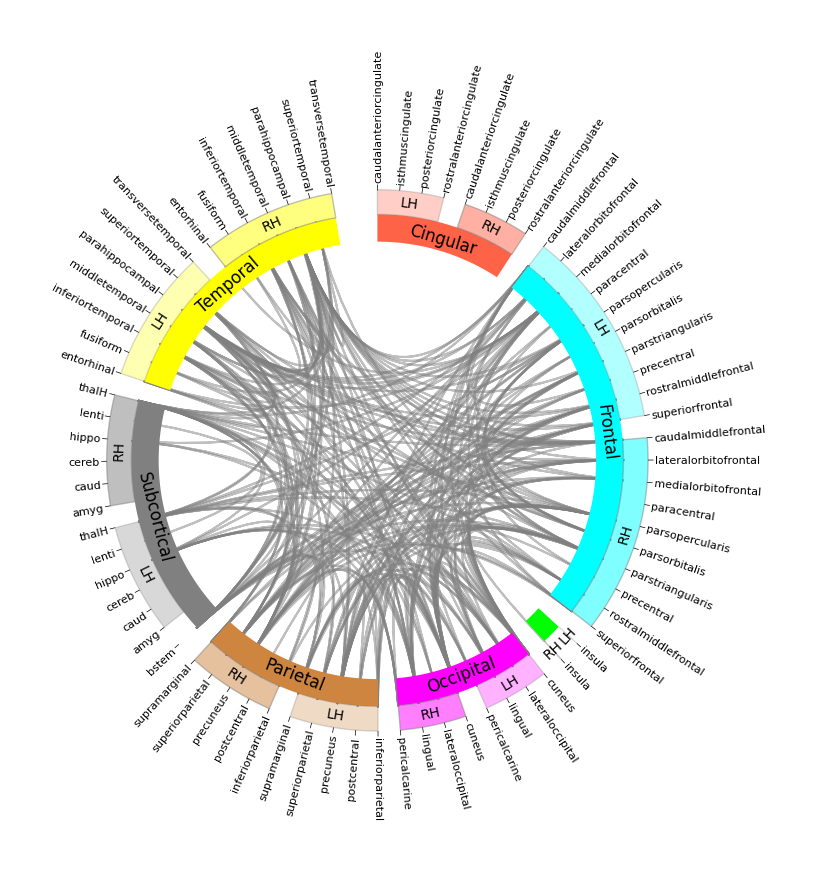

In [20]:
int_df = pd.merge(links_for_overlap['gc_PT: Ses2'], links_for_overlap['gc_FT'], how ='outer')
#int_df = pd.merge(links_for_overlap['fc_PT: Ses2'], links_for_overlap['fc_PT: Ses1'], how ='outer')

all_l = len(int_df)
int_df = int_df.drop_duplicates(subset=['n_source', 'n_target'], keep=False)

print('Divergence FC: ', len(int_df)/all_l)
#int_df= pd.merge(links_for_overlap['gc_PT: Ses2'], links_for_overlap['gc_FT'], how ='outer')
#int_df = int_df.drop_duplicates(subset=['n_source', 'n_target'], keep=False)


# initialize sectors 
sectors = {}
for lobe in np.unique(nodes.lobe.values): 
    sectors[lobe] = len(nodes[nodes.lobe == lobe])
    

circos = Circos({'ROIS': 75}, space=5, start=0, end=360 )
for i, sector in enumerate(circos.sectors):
    track = sector.add_track((90, 99))
    pos_list = list(range(0, int(sector.size) ))
    track.xticks(pos_list,nodes.region.values, label_orientation="vertical")
    
    start = sector.start
    for i, lobe in enumerate(sectors.keys()):
        sector.rect(start, start + sectors[lobe]-1, 
                r_lim=(80,90),color=colors[i], alpha=1)
        
        if lobe != 'I':
            sector.text(lobe_names[lobe], 
                    (start+ start + sectors[lobe]-1)/2, color='black', 
                   r=81, size=12)
              
        ## hemi 
        if lobe != 'S':
            sector.rect(start, start + sectors[lobe]/2-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
            
            sector.text('LH', 
                    (start+ start + sectors[lobe]/2 -1)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)
            sector.text('RH', 
                    (start+ sectors[lobe]/2 + start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
            
        else: 
            sector.rect(start+1, start + sectors[lobe]/2 -0.5, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
                
            sector.text('LH', 
                    (start+1 + start + sectors[lobe]/2 -0.5)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2 + 0.5, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)

            sector.text('RH', 
                    (start+ sectors[lobe]/2 + 0.5+ start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
             
        start += sectors[lobe]
        
for i, row in int_df.iterrows():
    
    #if row.original < 0 :
    #color='blue'
    #elif nodes.iloc[int(row.n_source)].lobe == nodes.iloc[int(row.n_target)].lobe:
    #    color = 'gray'
    #else:
    color = 'gray'
    circos.link(('ROIS', row.n_source,row.n_source),
                ('ROIS', row.n_target,row.n_target), direction=1, 
                color=color, lw=1.5)
#circos.savefig("test.png".format(group, connectome))    
circos.savefig("divergence_GC_PTSes1_PTSes2.png".format(group, connectome))

### take top differences 

0.11679919435309866


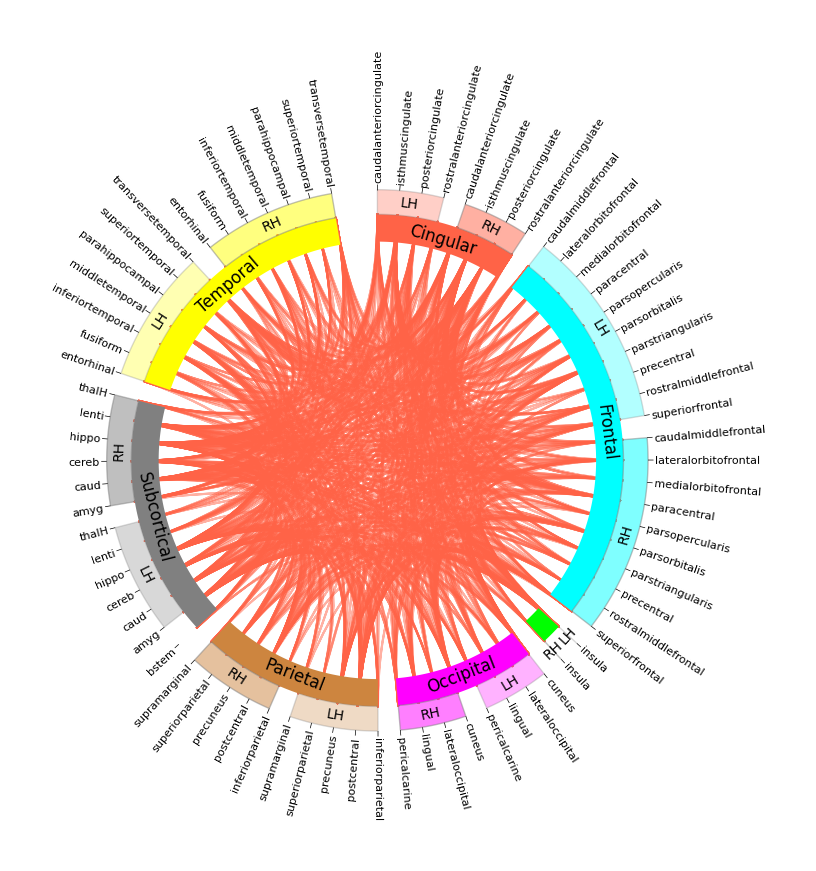

In [13]:
### FC 

diff = abs(fc_group['PT: Ses2'].copy() - fc_group['FT'].values.copy())

## get thresholds
idx = np.triu_indices_from(diff, k = 1)
l = np.abs(diff[idx])
l = np.sort(np.array(l).ravel())
t = l[-int(len(l)*0.25)]
print(t)

matrix = diff

data = []

for pair in np.arange(len(idx[0])):
    x,y = idx[0][pair],idx[1][pair]
    cutoff = t
    
    if abs(matrix[x,y]) > cutoff:  
        data.append([x,y, 1, matrix[x,y]])
        
links = pd.DataFrame(data, columns=['source', 'target', 'value', 'original'])
for i, row in links.iterrows():
    links.loc[i, 'n_source'] = np.int32(nodes[nodes.new_label==row.source].index[0])
    links.loc[i, 'n_target'] = np.int32(nodes[nodes.new_label==row.target].index[0])
    
links['n_source'] = links['n_source'].astype(np.int32)
links['n_target'] = links['n_target'].astype(np.int32)

### plot

# initialize sectors 
sectors = {}
for lobe in np.unique(nodes.lobe.values): 
    sectors[lobe] = len(nodes[nodes.lobe == lobe])
    

circos = Circos({'ROIS': 75}, space=5, start=0, end=360 )
for i, sector in enumerate(circos.sectors):
    track = sector.add_track((90, 99))
    pos_list = list(range(0, int(sector.size) ))
    track.xticks(pos_list,nodes.region.values, label_orientation="vertical")
    
    start = sector.start
    for i, lobe in enumerate(sectors.keys()):
        sector.rect(start, start + sectors[lobe]-1, 
                r_lim=(80,90),color=colors[i], alpha=1)
        
        if lobe != 'I':
            sector.text(lobe_names[lobe], 
                    (start+ start + sectors[lobe]-1)/2, color='black', 
                   r=81, size=12)
              
        ## hemi 
        if lobe != 'S':
            sector.rect(start, start + sectors[lobe]/2-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
            
            sector.text('LH', 
                    (start+ start + sectors[lobe]/2 -1)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)
            sector.text('RH', 
                    (start+ sectors[lobe]/2 + start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
            
        else: 
            sector.rect(start+1, start + sectors[lobe]/2 -0.5, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
                
            sector.text('LH', 
                    (start+1 + start + sectors[lobe]/2 -0.5)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2 + 0.5, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)

            sector.text('RH', 
                    (start+ sectors[lobe]/2 + 0.5+ start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
             
        start += sectors[lobe]
        
for i, row in links.iterrows():
    
    if row.original < 0 :
        color='blue'
    #elif nodes.iloc[int(row.n_source)].lobe == nodes.iloc[int(row.n_target)].lobe:
    #    color = 'gray'
    else:
        color = 'tomato'
    circos.link(('ROIS', row.n_source,row.n_source),
                ('ROIS', row.n_target,row.n_target), direction=1, 
                color=color, lw=1.5)
    
circos.savefig("absolute_diff_GC_FTvsPTs2.png".format(group, connectome, t))


In [ ]:

# initialize sectors 
sectors = {}
for lobe in np.unique(nodes.lobe.values): 
    sectors[lobe] = len(nodes[nodes.lobe == lobe])
    

circos = Circos({'ROIS': 75}, space=5, start=0, end=360 )
for i, sector in enumerate(circos.sectors):
    track = sector.add_track((90, 99))
    pos_list = list(range(0, int(sector.size) ))
    track.xticks(pos_list,nodes.region.values, label_orientation="vertical")
    
    start = sector.start
    for i, lobe in enumerate(sectors.keys()):
        sector.rect(start, start + sectors[lobe]-1, 
                r_lim=(80,90),color=colors[i], alpha=1)
        
        if lobe != 'I':
            sector.text(lobe_names[lobe], 
                    (start+ start + sectors[lobe]-1)/2, color='black', 
                   r=81, size=12)
              
        ## hemi 
        if lobe != 'S':
            sector.rect(start, start + sectors[lobe]/2-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
            
            sector.text('LH', 
                    (start+ start + sectors[lobe]/2 -1)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)
            sector.text('RH', 
                    (start+ sectors[lobe]/2 + start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
            
        else: 
            sector.rect(start+1, start + sectors[lobe]/2 -0.5, 
                r_lim=(90, 99), color=colors[i], alpha=0.3, 
                                ec='gray', lw=1)
                
            sector.text('LH', 
                    (start+1 + start + sectors[lobe]/2 -0.5)/2, color='black', 
                   r=92, size=10)
            
            sector.rect(start+ sectors[lobe]/2 + 0.5, start + sectors[lobe]-1, 
                r_lim=(90, 99), color=colors[i], alpha=0.5, 
                                ec='gray', lw=1)

            sector.text('RH', 
                    (start+ sectors[lobe]/2 + 0.5+ start + sectors[lobe]-1)/2, color='black', 
                   r=92, size=10)
             
        start += sectors[lobe]
        
for i, row in links.iterrows():
    
    if row.original < 0 :
        color='blue'
    #elif nodes.iloc[int(row.n_source)].lobe == nodes.iloc[int(row.n_target)].lobe:
    #    color = 'gray'
    else:
        color = 'tomato'
    circos.link(('ROIS', row.n_source,row.n_source),
                ('ROIS', row.n_target,row.n_target), direction=1, 
                color=color, lw=1.5)
    
circos.savefig("{}_{}_{}.png".format(group, connectome, t))

### Correlation

In [21]:
## correlation
df_p = pd.DataFrame()
df_r = pd.DataFrame()

for i, connectome in enumerate(['fc', 'gc']):
    for comparison in [['PT: Ses1', 'PT: Ses2'], ['PT: Ses2', 'FT']]:
        group1 , group2 = comparison[0], comparison[1]

        if connectome == 'gc':
            matrix1 = gc_group[group1].values.copy()
            matrix2 = gc_group[group2].values.copy()
        else: 
            matrix1 = fc_groups[group1]
            matrix2 = fc_groups[group2]
    
        idx = np.triu_indices_from(matrix1, k = 1)
        c = pg.corr(matrix1[idx], matrix2[idx])
        
        df_r.loc[i, '{}_{}'.format(group1, group2)] = c.r.values[0]
        df_p.loc[i, '{}_{}'.format(group1, group2)] = c['p-val'].values[0]
        

In [22]:
pg.multicomp(df_p.values.ravel(), method='fdr_bh')

(array([ True,  True,  True,  True]),
 array([0.00000000e+00, 0.00000000e+00, 6.65029089e-39, 0.00000000e+00]))

In [25]:
df_r

PT: Ses1_PT: Ses2  PT: Ses2_FT
0           0.768874     0.948575
1           0.244021     0.982521

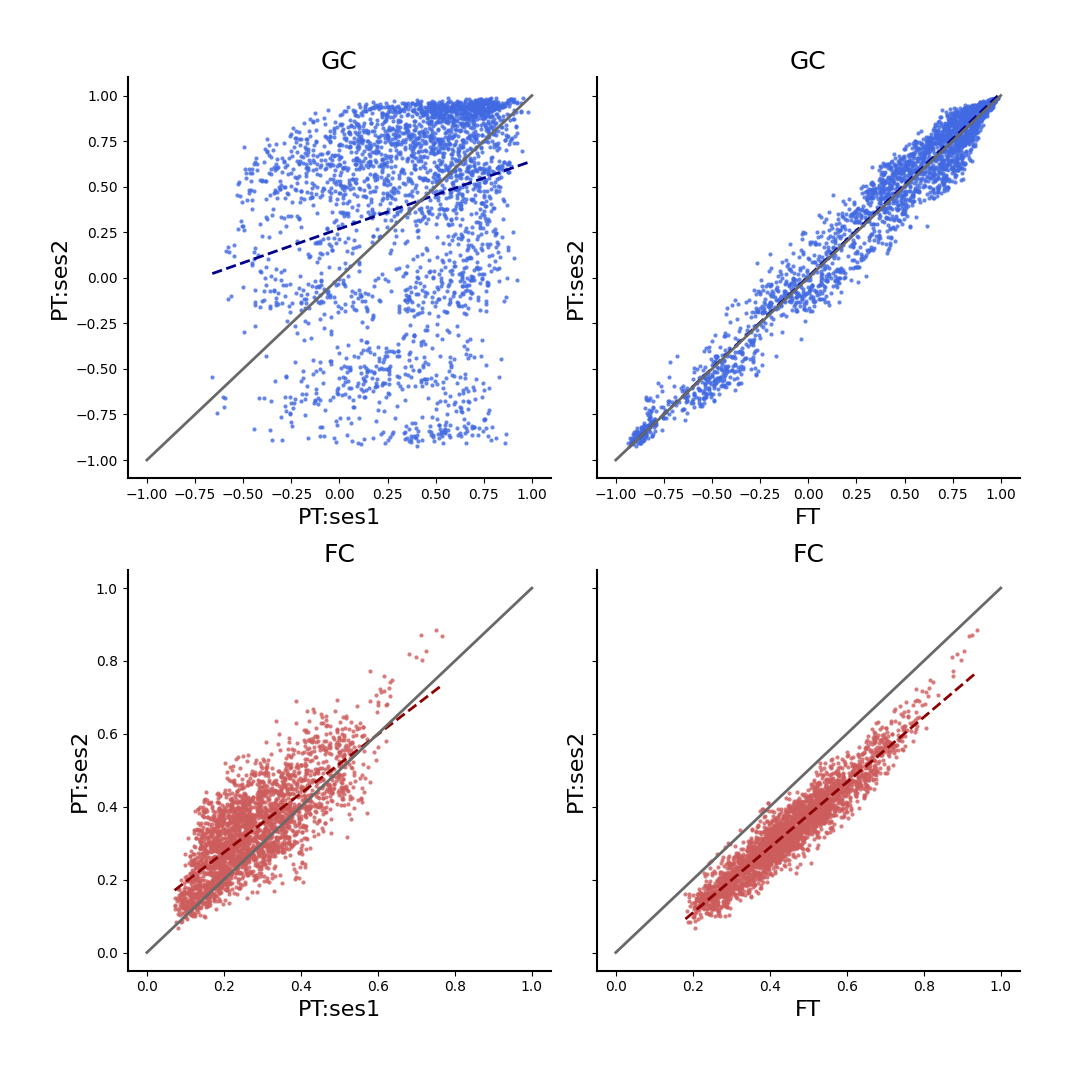

In [31]:
## correlation
df_p = pd.DataFrame()
df_r = pd.DataFrame()

fig, axs = plt.subplots(2,2, figsize=(10,10), sharex='row', sharey='row')
axs = axs.ravel()

ax = 0
for i, connectome in enumerate(['gc', 'fc']):
    for comparison in [['PT: Ses1', 'PT: Ses2'], [ 'FT', 'PT: Ses2']]:
        group1 , group2 = comparison[0], comparison[1]
        
        if group1 == 'PT: Ses1':
            name1 = 'PT:ses1'
            name2 = 'PT:ses2'
        elif group1 == 'FT':
            name1 = 'FT'
            name2 = 'PT:ses2'

        if connectome == 'gc':
            matrix1 = gc_group[group1].values.copy()
            matrix2 = gc_group[group2].values.copy()
        else: 
            matrix1 = fc_groups[group1]
            matrix2 = fc_groups[group2]
    
        idx = np.triu_indices_from(matrix1, k = 1)
        #c = pg.corr(matrix1[idx], matrix2[idx])
        #df_r.loc[i, '{}_{}'.format(group1, group2)] = c.r.values[0]
        #df_p.loc[i, '{}_{}'.format(group1, group2)] = c['p-val'].values[0]
        
        if connectome == 'fc':
            c='indianred'
            line = 'darkred'
            name = 'FC'
            pts = [0,1]
        else:
            c= 'royalblue'
            line = 'darkblue'
            name= 'GC'
            pts = [-1,1]
        
        axs[ax].scatter(matrix1[idx], matrix2[idx], c=c, alpha=.8)
        
        x = matrix1[idx]
        y = matrix2[idx]
        ind = np.argsort(x)
        m, b = np.polyfit(np.float32(x), np.float32(y), 1)
        axs[ax].plot(x[ind], m* x[ind] + b, c = line, linestyle='--', linewidth=2)
        
        axs[ax].plot(pts,pts, c = 'dimgray', linestyle='-', linewidth=2)
        
        
        axs[ax].set_title('{}'.format(name), fontsize=18)
        axs[ax].set_xlabel('{}'.format(name1), fontsize=16)
        axs[ax].set_ylabel('{}'.format(name2), fontsize=16)
        ax = ax + 1
for x in axs:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        x.spines[axis].set_linewidth(1.5)
plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/correlation_within_group_between_correlomes.jpg', dpi=300)
plt.savefig('../../Results/GC_FC_paper/update_figures/correlation_within_group_between_correlomes.jpg', dpi=300)
plt.show()

### Plotting the colours on PCA

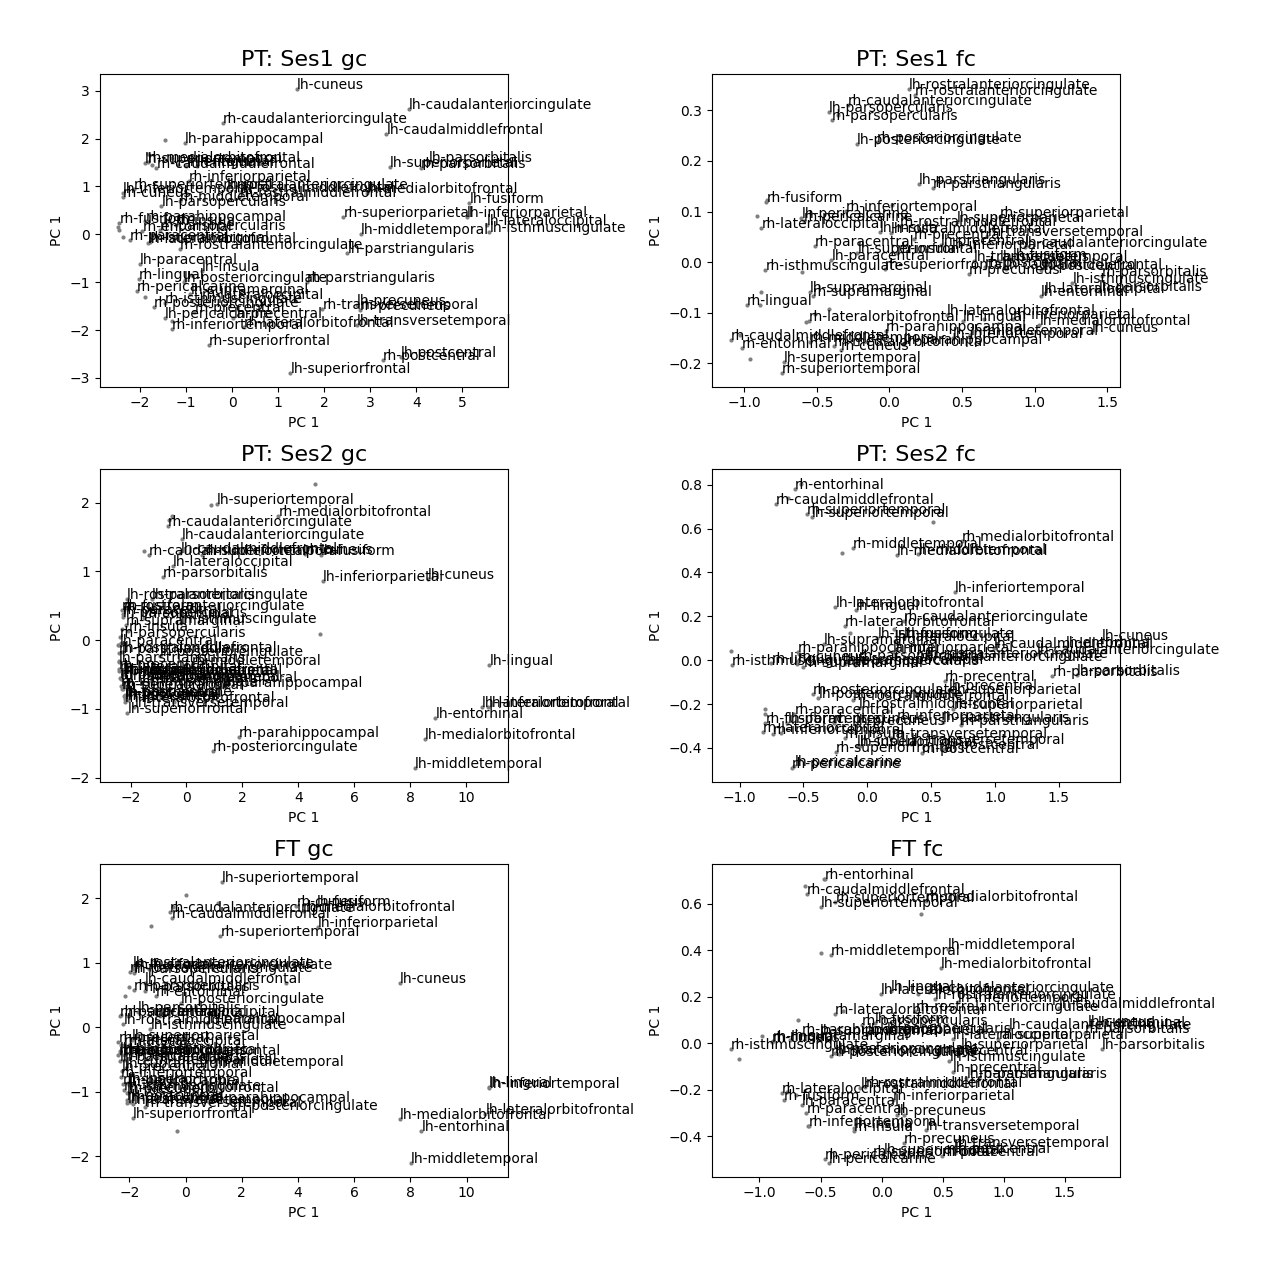

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster 
from sklearn.decomposition import PCA

ig, ax = plt.subplots(3,2, figsize=(12,12), sharex=False, sharey=False)
for g, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    for t, correlome in enumerate(['gc', 'fc']):
        
        if correlome == 'gc':
            data = gc_group[group].values
        else: 
            data = fc_groups[group]
    
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)

        ax[g,t].scatter(reduced_data[:,0], reduced_data[:,1], color='gray')

        for i, txt in enumerate(relabeled_encoding['ROI'].values[13:],):
            ax[g,t].annotate(txt, (reduced_data[:,0][i], reduced_data[:,1][i]), fontsize=10)
    
        ax[g,t].set_title('{} {}'.format(group, correlome), fontsize=16)
        ax[g,t].set_xlabel('PC 1')
        ax[g,t].set_ylabel('PC 1')

        plt.tight_layout()
plt.show()

In [165]:
import seaborn as sns
import itertools
from scipy.spatial.distance import pdist, euclidean
from sklearn.preprocessing import MinMaxScaler

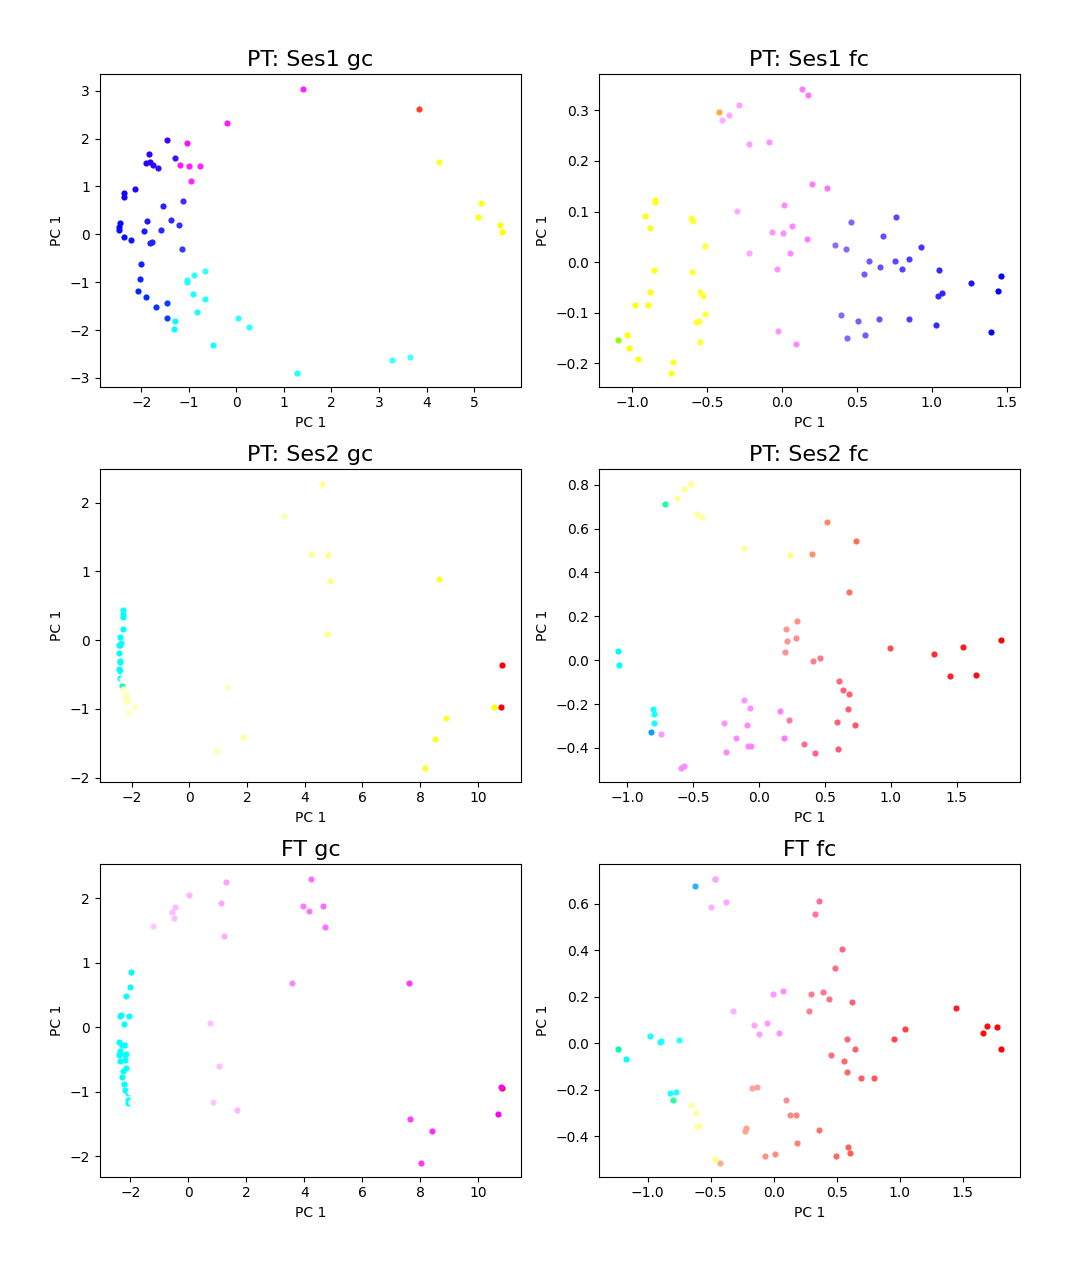

In [164]:
ig, ax = plt.subplots(3,2, figsize=(10,12), sharex=False, sharey=False)
for g, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    for t, correlome in enumerate(['gc', 'fc']):
        
        if correlome == 'gc':
            data = gc_group[group].values
        else: 
            data = fc_groups[group]
    
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)
        
        Npoints = 3
        c = [list(x) for x in itertools.combinations(range(len(reduced_data)), Npoints )]
        distances = []
        for i in c:    
            distances.append(np.mean(pdist(reduced_data[i,:]))) # pdist: a method of computing all pairwise Euclidean distances in a condensed way.
        ind = distances.index(max(distances)) # finding the index of the max mean distance
        rows = c[ind]
        
        all_distances = []
        for point in range(len(reduced_data)):
            all_distances.append([euclidean(reduced_data[point,:],reduced_data[rows[i],:]) for i in range(Npoints) ])
        
        all_distances = np.array(all_distances)
        for i in range(Npoints):
            all_distances[:,i] = 1 - MinMaxScaler((0,1)).fit_transform(all_distances[:,i].reshape(-1, 1)).reshape(1, -1)
        
        thr_dist = []
        for idx in range(Npoints):
            d = all_distances[rows][:, idx]
            d = d[d!=0]
            thr_dist.append(d[d!=1][0])
            
        for idx in range(Npoints):
            all_distances[:,idx][all_distances[:,idx] > thr_dist[idx]] = 1
            
        all_distances = all_distances * [255,255,255]
        
        for idx in range(len(reduced_data)):
            ax[g,t].scatter(reduced_data[idx,0], reduced_data[idx,1],
                            color=all_distances[idx].astype(int)/255., s=20)
        #for idx in rows: 
        #    ax[g,t].scatter(reduced_data[idx,0], reduced_data[idx,1], color='red', s=20)
            
    
        #for i, txt in enumerate(relabeled_encoding['ROI'].values[13:],):
        #    ax[g,t].annotate(txt, (reduced_data[:,0][i], reduced_data[:,1][i]), fontsize=10)
    
        ax[g,t].set_title('{} {}'.format(group, correlome), fontsize=16)
        ax[g,t].set_xlabel('PC 1')
        ax[g,t].set_ylabel('PC 1')

        plt.tight_layout()
plt.show()

In [105]:
# red [255,0,0]
# green [0,255,0]
# blue [0,255,0]

all_distances[idx].astype(int)

array([255,  64,  40])

In [156]:
import itertools
from scipy.spatial.distance import pdist, euclidean
from sklearn.preprocessing import MinMaxScaler

thr_dist

[0.16830661017018367, 0.6941153218386508, 0.6322146094921588]

In [159]:
all_distances[:,0][all_distances[:,0] > thr_dist[0]] = 1

array([190.96907244, 221.8261168 , 242.39218172, 246.68141724,
        98.62092316,  93.79164654, 154.52008073, 150.22248082,
       152.50833021, 101.94256089, 108.51850065, 140.7888939 ,
       143.35229655,  74.49457553,  47.90781632, 107.06261762,
       255.        , 161.45711008,  63.27813942, 147.50701461,
        71.41203211, 152.28617746, 112.46061811, 139.04631597,
        88.60083976, 100.23267458, 157.88701612,  55.45065673,
        61.36446373, 130.72735773,  82.55245147, 134.79610637,
        44.92207611,  28.05540848,  55.2001579 ,  35.90880416,
       110.4534334 ,  51.70837361,   0.        ,  34.36169503,
        71.13990576,  28.91948827, 122.69526461,  65.75326973,
        48.81999733,  50.61460147,  90.12726257, 241.7636242 ,
       169.81265488,  60.43213708, 138.51409857,  69.03909187,
       142.18594204, 114.77635554, 126.19546961,  92.05585725,
        93.30131245, 183.89525399,  64.39207723,  40.71698394,
       147.50946774,  82.03571377, 127.23023665,  42.91

In [110]:
from sklearn.preprocessing import MinMaxScaler
all_distances = np.array(all_distances)
for i in range(Npoints):
    all_distances[:,i] = 1 - MinMaxScaler((0,1)).fit_transform(all_distances[:,i].reshape(-1, 1)).reshape(1, -1)


In [152]:
thr_dist = []
for idx in range(Npoints):
    d = all_distances[rows][:, 0]
    d = d[d!=0]
    thr_dist.append(d[d!=1][0])

In [151]:
d

0.16830661017018367

In [135]:
thr_dist = []


[all_distances[rows][:, idx]< ) for idx in range(Npoints)]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [102]:
all_distances * [255,255,255]

array([[190.96907244,  63.45414344,  75.50260141],
       [221.8261168 ,  29.13396125,  39.07649798],
       [242.39218172,   9.11283868,  13.45592514],
       [246.68141724,   2.44435113,   5.46755309],
       [ 98.62092316, 155.62292442, 172.59307091],
       [ 93.79164654, 160.9669462 , 172.77624407],
       [154.52008073,  98.05363112, 119.4568867 ],
       [150.22248082, 104.63429689, 113.82418281],
       [152.50833021, 102.3840428 , 116.26342559],
       [101.94256089, 149.89239068, 176.83874531],
       [108.51850065, 143.03694518, 170.86432085],
       [140.7888939 , 107.37052953, 137.26419453],
       [143.35229655, 101.3287196 , 133.90712362],
       [ 74.49457553, 180.46900312, 176.75555592],
       [ 47.90781632, 201.97277278, 159.64404121],
       [107.06261762, 147.66167146, 162.37792009],
       [255.        ,   0.        ,   0.        ],
       [161.45711008,  92.59815748,  97.78734012],
       [ 63.27813942, 175.79563493, 133.2845516 ],
       [147.50701461,  96.28355

(75, 2)

In [57]:
reduced_data

array([[ 1.0440966 ,  0.06320021],
       [ 1.448612  ,  0.15210767],
       [ 1.6910254 ,  0.07609391],
       [ 1.7707093 ,  0.06838734],
       [-0.0570138 ,  0.08959132],
       [-0.11698433,  0.03934263],
       [ 0.6227228 ,  0.17974278],
       [ 0.5547279 , -0.07495973],
       [ 0.5817746 ,  0.01833061],
       [-0.00557226,  0.2111547 ],
       [ 0.07515962,  0.22350661],
       [ 0.48776886,  0.32605907],
       [ 0.54384106,  0.40534252],
       [-0.34772795, -0.04755215],
       [-0.6524932 , -0.26758096],
       [ 0.04134249,  0.0451974 ],
       [ 1.8012159 , -0.02583618],
       [ 0.69456494, -0.15093176],
       [-0.4287719 , -0.5130613 ],
       [ 0.60122746, -0.47067127],
       [-0.38446453, -0.04372269],
       [ 0.58208174, -0.12155298],
       [ 0.12807533, -0.30963638],
       [ 0.4378301 ,  0.19096911],
       [-0.17271483, -0.19431643],
       [ 0.01419919, -0.47508815],
       [ 0.6450165 , -0.02277893],
       [-0.4947454 ,  0.5848352 ],
       [-0.5032802 ,